In [3]:
from data_loader import DataGenerator
from datetime import datetime
from model import lstm_builder
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
import numpy as np
import warnings
from config import (model_config, data_generator_config, load_from_file,
                    n_epochs, model_name, tb_logs_path, model_checkpoint_file, test_seq_path)
from tensorflow.keras.losses import MSE, MAE
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm
np.set_printoptions(suppress=True)
n_batches = 320

In [4]:
def get_err_of_model(model, X, err_f, shape):
    preds = model.predict(X)
    errs = err_f(X.reshape(shape), preds.reshape(shape))
    err_of_mods = []
    for i, m_ix in enumerate(modifs_idx):
        if m_ix.shape[0] > 3 and m_ix.shape[0] < 50:
            err_of_mods.append(err_f(X[i, m_ix].flatten(),
                                     preds[i, m_ix].flatten()))
    overall_err_med = np.median(errs)
    overall_err_mean = np.mean(errs)
    mods_err_med = np.median(err_of_mods)
    mods_err_mean = np.mean(err_of_mods)
    return {"err (med, mean)": (overall_err_med, overall_err_mean), 
            "modifications_err (med, mean)": (mods_err_med, mods_err_mean)}

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_roll_mses(mse):
    roll_mses = []
    for idx in rolling_window(np.arange(mse.shape[0]), 4):
        roll_mses.append(np.median(mse))
    return np.array(roll_mses)

def get_y(X, preds, mses, threshold):
    y_true = []
    y_pred = []
    for sample, pred, mse in tqdm(zip(X, preds, mses)):
        if np.where(mse > threshold):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [5]:
data_generator_config['quality_threshold'] = 20.5
data_generator_config['test'] = True
data_generator_config['seq_path'] = test_seq_path
data_generator_config['load2ram'] = False
data_generator_config['step_len'] = 64
# data_generator_config['motifs'] = ["CCAGG", "CCTGG", "GATC"]
data_generator_config

{'sample_len': 512,
 'batch_size': 1000,
 'quality_threshold': 20.5,
 'normalize': 'MEDIAN',
 'random_sample': True,
 'step_len': 64,
 'load2ram': False,
 'test': True,
 'seq_path': '/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5'}

In [6]:
data_loader = DataGenerator(**data_generator_config)

/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5


In [7]:
X = []
modifs_idx = []
modifs_type = []
for _ in tqdm(range(n_batches)):
    x, m_idx, type_ = next(data_loader)
    X.append(x)
    modifs_idx.append(m_idx)
    modifs_type.append(type_)

 13%|█▎        | 43/320 [02:04<07:46,  1.68s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160809_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_2_08_07_16_80510_ch180_read404_strand.fast5


 89%|████████▉ | 285/320 [14:28<00:55,  1.59s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch432_read1037_strand.fast5


100%|██████████| 320/320 [16:06<00:00,  3.02s/it]


In [8]:
X = np.array(X).reshape(n_batches*data_loader.batch_size, 
                        data_loader.sample_len, 1)
shape_ = (n_batches*data_loader.batch_size, data_loader.sample_len)
modifs_idx = np.array(modifs_idx).reshape(shape_[0])
modifs_idx = modifs_idx.flatten()

In [9]:
# from tensorflow.keras import layers
# clear_session()
# model_lstm = load_model(r"2202/lstm.h5", custom_objects={'ELU': layers.ELU})

In [10]:
from tensorflow.keras import layers
clear_session()
model_lstm = load_model(r"2202/lstm.h5", custom_objects={'ELU': layers.ELU})
print("MSE: ", get_err_of_model(model_lstm, X, MSE, shape_))
print("MAE: ", get_err_of_model(model_lstm, X, MAE, shape_))

MSE:  {'err (med, mean)': (0.019941047, 0.02093672), 'modifications_err (med, mean)': (0.050100934, 0.06389622)}
MAE:  {'err (med, mean)': (0.10039072, 0.10096123), 'modifications_err (med, mean)': (0.16117118, 0.17453104)}


In [12]:
preds_lstm = model_lstm.predict(X)
X_shaped = X.reshape(shape_)
preds_shaped = preds_lstm.reshape(shape_)

In [13]:
now = datetime.now()
model_lstm.predict(X[:1000])
print("pred speed _lstm: ", datetime.now() - now)

pred speed _lstm:  0:00:03.881059


In [14]:
with_modif = np.array([i for i, ix in enumerate(modifs_idx) if 3 < len(ix) < 50])
without_modif = np.array([i for i, ix in enumerate(modifs_idx) if not len(ix)])
print(with_modif.shape)
print(without_modif.shape)

(81792,)
(235494,)


In [15]:
without_modif = without_modif[::2]

In [16]:
X_cropped = X[:, 100:-100]
preds_cropped_lstm = preds_lstm[:, 100:-100]

In [17]:
modif_ix = []
with_modif_in_middle = []
for ix in with_modif:
    if modifs_idx[ix][0] > 200 and modifs_idx[ix][-1] < 312:
        modif_ix.append(modifs_idx[ix] - 100)
        with_modif_in_middle.append(ix)
with_modif_in_middle = np.array(with_modif_in_middle)

In [19]:
X_cropped = X_cropped.reshape(X_cropped.shape[0], X_cropped.shape[1])
mses_lstm = ((X_cropped - preds_cropped_lstm)**2)

In [20]:
print(np.mean(mses_lstm[without_modif]))
print(np.mean(mses_lstm[with_modif]))
# print(np.mean(mae_lstm))

0.020710483398931334
0.022270602070544678


In [21]:
without_modif_set = set(without_modif)
with_modif_in_middle_set = set(with_modif_in_middle)
if len(without_modif_set.intersection(set(with_modif_in_middle))):
    raise ValueError("hmm")

In [22]:
np.median(mses_lstm[without_modif].mean(1)) / np.median(mses_lstm[with_modif_in_middle].mean(1))

0.8536531020699427

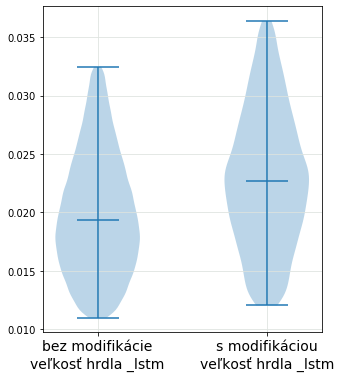

In [23]:
avg_mse_with_lstm = mses_lstm[with_modif_in_middle].mean(1)
avg_mse_without_lstm = mses_lstm[without_modif].mean(1)

p_min_without_lstm = np.percentile(avg_mse_without_lstm, 5)
p_max_without_lstm = np.percentile(avg_mse_without_lstm, 95)
p_min_with_lstm = np.percentile(avg_mse_with_lstm, 5)
p_max_with_lstm = np.percentile(avg_mse_with_lstm, 95)
without_lstm_avg = avg_mse_without_lstm[(avg_mse_without_lstm > p_min_without_lstm) 
                              & (avg_mse_without_lstm < p_max_without_lstm)]
with_lstm_avg = avg_mse_with_lstm[(avg_mse_with_lstm > p_min_with_lstm) 
                        & (avg_mse_with_lstm < p_max_with_lstm)]

plt.figure(figsize=(5, 6))
plt.violinplot([without_lstm_avg, with_lstm_avg], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla _lstm', 
                     's modifikáciou\nveľkosť hrdla _lstm'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_avg_lstm.png')
plt.show()



In [ ]:
# median_rolled_mses_without32 = []
# median_rolled_mses_with32 = []
# median_rolled_mses_without_lstm = []
# median_rolled_mses_with_lstm = []

# for idx in tqdm(range(len(mses_lstm))):
#     if idx not in without_modif_set and idx not in with_modif_in_middle_set:
#         continue
#     if idx in without_modif_set:
#         median_rolled_mses_without_lstm.append(get_roll_mses(mses_lstm[idx]))

#     if idx in with_modif_in_middle_set:
#         median_rolled_mses_with_lstm.append(get_roll_mses(mses_lstm[idx]))

# avg_mse_with_lstm = mses_lstm[with_modif_in_middle].mean(1)
# avg_mse_without_lstm = mses_lstm[without_modif].mean(1)

# median_rolled_mses_without_lstm = np.array(median_rolled_mses_without_lstm)
# median_rolled_mses_with_lstm = np.array(median_rolled_mses_with_lstm)
# avg_mse_without_lstm = np.array(avg_mse_without_lstm)
# avg_mse_with_lstm = np.array(avg_mse_with_lstm)

# with open("evaluation_lstm.npz", "wb") as f:
#     np.savez(f, mses_lstm, median_rolled_mses_without_lstm, median_rolled_mses_with_lstm)

In [24]:
import os
from datetime import datetime
os.cpu_count()

40

In [25]:
train_mses = mses_lstm[without_modif]
test_mses = mses_lstm[with_modif_in_middle]

159444it [02:12, 1500.80it/s]

In [26]:
def axis1_wrapper(f, x):
    return f(x, axis=1)

In [27]:
from collections import Counter
def percentile1(x, axis=1):
    return np.percentile(x, 25, axis=axis)
def percentile2(x, axis=1):
    return np.percentile(x, 75, axis=axis)
def num_higher_mean(x, axis=1):
    means = x.mean(1)
    nums = np.array([np.where(xx > mean_)[0].shape[0]
                     for xx, mean_ in zip(x, means)])
    return nums

In [31]:
os.cpu_count()

40

In [32]:
functions = [np.mean, np.median, np.ptp, percentile1,
             percentile2, np.std, np.var, np.argmax, np.argmin,
             num_higher_mean, np.max, np.min, np.sum, np.prod]

In [33]:
train_columns = []
test_columns = []
for f in tqdm(functions):
    train_columns.append(axis1_wrapper(f, train_mses))
    test_columns.append(axis1_wrapper(f, test_mses))
X = np.column_stack(train_columns)
X_test = np.column_stack(test_columns)


100%|██████████| 14/14 [00:06<00:00,  2.02it/s]


In [34]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X, test_size=0.2, shuffle=True, random_state=1)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

import pickle

with open("X.pickle","wb") as f:
    pickle.dump(scaler, f)
    pickle.dump(X_train, f)
    pickle.dump(X_val, f)
    pickle.dump(X_test, f)

# idx = np.random.randint(0, X.shape[0], 320000)
# now = datetime.now()
# clf = make_pipeline(Normalizer(), OneClassSVM(gamma='auto'))
# clf = OneClassSVM(cache_size=128000)
# clf = IsolationForest(n_jobs=32)
# clf.fit(X[idx])
# print(datetime.now() - now)

In [168]:
from bayes_opt import BayesianOptimization
import lsanomaly
import copy

best_score = 0

In [173]:
def get_diff_score(sigma, rho, n_kernels_max, threshold):
    global best_score
    n_kernels_max = int(n_kernels_max)
    clf = lsanomaly.LSAnomaly(sigma=sigma, rho=rho, n_kernels_max=n_kernels_max)
    clf.fit(X_train)
    y_val = clf.predict_proba(X_val)[:, 1]
    y_test = clf.predict_proba(X_test)[:, 1]

    len_test = y_test.shape[0]
    len_val = y_val.shape[0]
    TP = y_test[y_test > threshold].shape[0]
    FP = y_val[y_val > threshold].shape[0]
    score = TP/len_test - FP/len_val
    if score > best_score:
        best_score = score
        best_model = copy.deepcopy(clf)
    return score

In [1]:
3/2 - 4/2

-0.5

In [ ]:
pbounds = {'sigma': (0.5, 15), 'rho': (0.01, 10), 'n_kernels_max': (100, 50000),
           'threshold': (0.01, 1)}
optimizer = BayesianOptimization(f=get_diff_score, pbounds=pbounds, random_state=1)
optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   |     k     | n_kern... |    rho    |   sigma   | threshold |
-------------------------------------------------------------------------------------


In [ ]:
# max_mse_with_lstm = median_rolled_mses_with_lstm.max(1)
# max_mse_without_lstm = median_rolled_mses_without_lstm.max(1)
# max_mse_without_lstm *= 2.5
# max_mse_with_lstm *= 2.5
# p_min_without_lstm = np.percentile(max_mse_without_lstm, 5)
# p_max_without_lstm = np.percentile(max_mse_without_lstm, 95)
# p_min_with_lstm = np.percentile(max_mse_with_lstm, 5)
# p_max_with_lstm = np.percentile(max_mse_with_lstm, 95)
# without_lstm_max = max_mse_without_lstm[(max_mse_without_lstm > p_min_without_lstm) 
#                               & (max_mse_without_lstm < p_max_without_lstm)]
# with_lstm_max = max_mse_with_lstm[(max_mse_with_lstm > p_min_with_lstm) 
#                         & (max_mse_with_lstm < p_max_with_lstm)]

# plt.figure(figsize=(5, 6))
# plt.violinplot([without_lstm_max, with_lstm_max], showmedians=True,
#                positions=[1, 2])
# plt.xticks([1, 2],
#            labels = ['bez modifikácie\nveľkosť hrdla _lstm', 
#                      's modifikáciou\nveľkosť hrdla _lstm'],
#           fontsize=14)
# plt.grid(color='#dee3df')
# plt.savefig('violinplots_max_lstm.png')
# plt.show()

In [ ]:
# preds = model1.predict(X)
# x = np.arange(X[29].flatten().shape[0])
# plt.plot(x, X[29].flatten(), label="vstup")
# plt.plot(x, preds_lstm[29].flatten(), label="výstup")
# plt.legend()
# plt.show()